In [ ]:
# Retrieves processed data from Yoo-Jung and makes simple calibration

In [1]:
#from astropy.io import fits
import numpy as np
#import glob
#import os
import pickle
import matplotlib.pyplot as plt
#from astropy.io import fits
#from scipy.optimize import curve_fit

from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

%matplotlib inline

In [2]:
# retrieve processed data arrays from pickle files

# single fiber
file = open('yoo_jung_single.pkl', 'rb')
dict_single = pickle.load(file)
file.close()

# 3 photonic lantern
file = open('yoo_jung_3PL.pkl', 'rb')
dict_3PL = pickle.load(file)
file.close()

# broadband image
file = open('yoo_jung_broadband.pkl', 'rb')
dict_broadband = pickle.load(file)
file.close()

In [3]:
# make bad pixel mask

# initialize
cube_bad = np.zeros((np.shape(dict_single['1100'])[0],np.shape(dict_single['1100'])[1],len(dict_single)))

idx = 0

for key in dict_single:
    
    cube_bad[:,:,idx] = dict_single[key]
    
    idx += 1

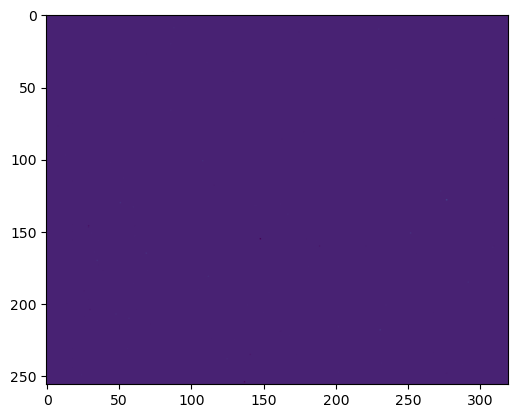

In [37]:
plt.imshow(np.median(cube_bad,axis=2))
plt.show()

In [42]:
plt.imshow(np.std(cube_bad,axis=2))
plt.show()

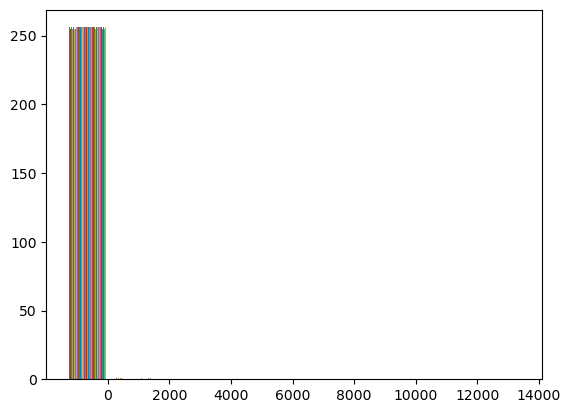

In [39]:
plt.hist(np.median(cube_bad,axis=2), bins=)
plt.show()

In [9]:
# centroid the single fiber images

dict_centroids = {}

for key in dict_single:
    
    #print(value)
    
    this_slice = dict_single[key]
    
    # ersatz bad pixel mask
    this_slice[0:125,:] = 0
    this_slice[140:,:] = 0
    
    #x1, y1 = centroid_1dg(this_slice)
    #x2, y2 = centroid_2dg(this_slice)
    x3, y3 = centroid_com(this_slice)
    x4, y4 = centroid_quadratic(this_slice)
    print('-------')
    print(key)
    print(str(x3)+', '+str(y3))
    print(str(x4)+', '+str(y4))
    
    dict_centroids[key] = (x4,y4)
    
    #plt.imshow(dict_single[key], origin='lower')
    #plt.scatter(x1, y1, color='white')
    #plt.scatter(x2, y2, color='blue')
    #plt.scatter(x3, y3, color='yellow')
    #plt.scatter(x4, y4, color='red')
    #plt.show()

-------
1100
87.34580319862474, 131.72319704233306
85.03786377864677, 131.89772826556515
-------
1680
282.0293623347662, 133.08331178694937
301.9801788491584, 133.23213765670403
-------
1340
213.85854660917374, 132.61568813907607
215.30878252514378, 132.89481839956434
-------
1360
219.34327871959815, 132.6676025636469
222.86945844527565, 132.9232897890987
-------
1120
102.32784319670414, 131.84805667889836
100.20426046850436, 131.9618274003124
-------
1160
130.41786128295476, 132.02965211702457
127.71033132256613, 132.0609486150821
-------
1320
206.56238836743745, 132.52137351506215
207.91323484171176, 132.8722124831927
-------
1480
251.6842063033571, 132.8732535250444
259.2472425510047, 133.04631243887036
-------
1300
198.504721159464, 132.51785119709507
199.8631324058905, 132.84157355680244
-------
1140
115.9725142962553, 131.94609656404432
114.51902504280329, 132.01547232078838
-------
1720
294.52811947915984, 133.2904479923226
310.0845150108871, 133.75680910662643
-------
1560
268.

In [10]:
dict_centroids

{'1100': (85.03786377864677, 131.89772826556515),
 '1680': (301.9801788491584, 133.23213765670403),
 '1340': (215.30878252514378, 132.89481839956434),
 '1360': (222.86945844527565, 132.9232897890987),
 '1120': (100.20426046850436, 131.9618274003124),
 '1160': (127.71033132256613, 132.0609486150821),
 '1320': (207.91323484171176, 132.8722124831927),
 '1480': (259.2472425510047, 133.04631243887036),
 '1300': (199.8631324058905, 132.84157355680244),
 '1140': (114.51902504280329, 132.01547232078838),
 '1720': (310.0845150108871, 133.75680910662643),
 '1560': (278.7704063561162, 133.11380766238187),
 '1540': (274.0752772371474, 133.10397969886301),
 '1700': (306.99674450785534, 133.2529176474882),
 '1080': (68.8075393381862, 131.84307416494235),
 '1740': (313.13299861264954, 133.78491773111728),
 '1280': (191.12797323946253, 132.8016492511797),
 '1500': (264.6399338280236, 133.0801317751667),
 '1520': (269.281311231587, 133.10624638370055),
 '1760': (276.9988686867068, 128.0024935871447),
 